# Árbol de decisión

En este notebook clasificaremos si una instancia tiene alto poder adquisitivo mediante árboles de decisión.

Se utilizarán dos preprocessings diferentes: uno con las variables utilizadas en la primera parte del trabajo práctico y otro utilizando todas las variables posibles del data frame pero antes habiendo equilibrado la cantidad de instancias 1 y 0...

In [1]:
# Modelo
from sklearn.tree import DecisionTreeClassifier

# Entrenamiento
from sklearn.model_selection import train_test_split, GridSearchCV

# Métricas
from sklearn.metrics import plot_roc_curve, classification_report, plot_confusion_matrix, roc_auc_score

# Gráficos
from matplotlib import pyplot as plt
import seaborn as sns
import graphviz
import dtreeviz.trees as dtreeviz

# Otros
import pandas as pd
import numpy as np
from preprocessing import preprocessing_base_parte_1
from preprocessing import preprocessing_equilibrado
import utils

In [2]:
df = utils.get_data()

### Modelo 1 - Preprocessing parte 1

Este árbol será entrenado con las siguientes variables:

* **Ganancia/Pérdida declara en la bolsa argentina**: `ganancia_perdida_declarada_bolsa_argentina`
* **Edad**: `edad`
* **Rol familiar registrado**: `rol_familiar_registrado`
* **Años estudiados**: `anios_estudiados`

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=112, stratify=Y)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

Buscaremos con GridSearch las mejores configuraciones para los siguientes hiperparámetros:
* criterion
* max_depth
* min_samples_leaf
* max_leaf_nodes
* min_impurity_decrease

Además se realizará mediante cross validation (Kfold con K = 10)

Y luego, si vemos que la altura dio muy alta buscaremos la menor altura entre ellas que obtengan un resultado similar.

In [4]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': range(5,22,2),
    'min_samples_leaf': np.linspace(0.0001, 0.001, 10),
    'max_leaf_nodes': [2**x for x in range(6, 18, 2)],
    'min_impurity_decrease': np.linspace(0, 0.1, 5)
}
model = DecisionTreeClassifier()

gscv_base = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=10, verbose=4)

In [5]:
gscv_base.fit(X_train_1, y_train_1)

Fitting 10 folds for each of 5400 candidates, totalling 54000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 596 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1280 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2164 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 4516 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 5984 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 7652 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 9512 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 11572 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 13824 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 16276 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 18920 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 21764 tasks  

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 22, 2),
                         'max_leaf_nodes': [64, 256, 1024, 4096, 16384, 65536],
                         'min_impurity_decrease': array([0.   , 0.025, 0.05 , 0.075, 0.1  ]),
                         'min_samples_leaf': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 ]),
                         'splitter': ['best']},
             scoring='roc_auc', verbose=4)

Veamos los hiperparámetros obtenidos.

In [6]:
print(gscv_base.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=19, max_leaf_nodes=64,
                       min_samples_leaf=0.00019999999999999998)


Vemos que efectivamente se obtuvieron hiperparámetros diferentes a los default. Sin embargo creemos que la altura es un tanto grande, veamos si podemos aplicar el principio de parsimonia

In [7]:
alturas = range(1, 25)
model = DecisionTreeClassifier()
params = {
    'criterion': ['entropy'],
    'max_depth': alturas,
    'min_samples_leaf': [0.0002],
    'max_leaf_nodes': [64]
}
gscv_base = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=10, verbose=4)

gscv_base.fit(X_train_1, y_train_1)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 225 out of 240 | elapsed:    4.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.6s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 25),
                         'max_leaf_nodes': [64], 'min_samples_leaf': [0.0002]},
             scoring='roc_auc', verbose=4)

In [8]:
resultados = pd.DataFrame({"Altura": alturas, "RocAUC": gscv_base.cv_results_['mean_test_score']})

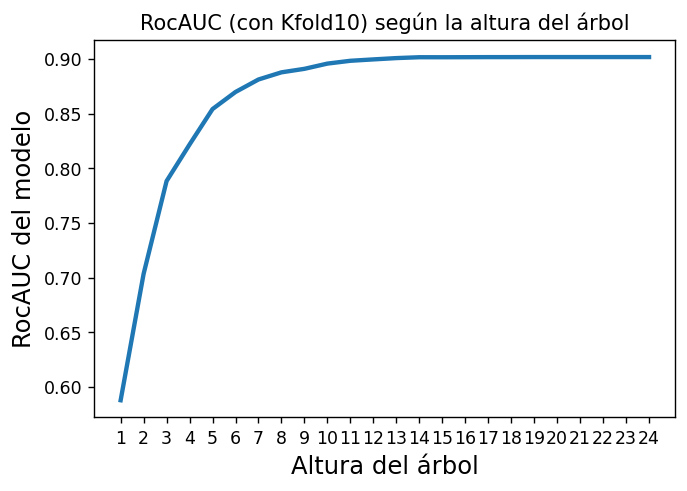

In [9]:
plt.figure(dpi=125)

sns.lineplot(data=resultados,
             x = "Altura",
             y = "RocAUC",
             palette="tab10", linewidth=2.5)

plt.title('RocAUC (con Kfold10) según la altura del árbol')
plt.xlabel("Altura del árbol", fontsize=14)
plt.ylabel("RocAUC del modelo", fontsize=14)
plt.xticks(alturas)

plt.show()

Podemos ver que luego de una altura de 13 para el árbol de decisión  la métrica de RocAUC se mantiene medianamente constante.

Por el principio de parsimonia, nos quedaremos con una altura de árbol en 13 para predecir la variable objetivo.

In [41]:
arbol1 = DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_leaf=0.0004, max_leaf_nodes=64)
arbol1.fit(X_train_1, y_train_1)

DecisionTreeClassifier(criterion='entropy', max_depth=13, max_leaf_nodes=64,
                       min_samples_leaf=0.0004)

Veamos un reporte de la clasificación

In [42]:
print(classification_report(y_test_1, arbol1.predict(X_test_1), digits=4))

              precision    recall  f1-score   support

           0     0.8651    0.9482    0.9048      6181
           1     0.7657    0.5337    0.6290      1960

    accuracy                         0.8484      8141
   macro avg     0.8154    0.7410    0.7669      8141
weighted avg     0.8412    0.8484    0.8384      8141



Se obtuvieron resultados muy intersantes, un accuracy del 84.84% un poco superior al realizado en la primera parte del trabajo práctico.

Buenos resultados para la precisión de cada una de las clases, un poco regular el recall de unos para el modelo pero compensado por el alto recall de ceros.


Veamos la curva ROC y su puntuación AUC

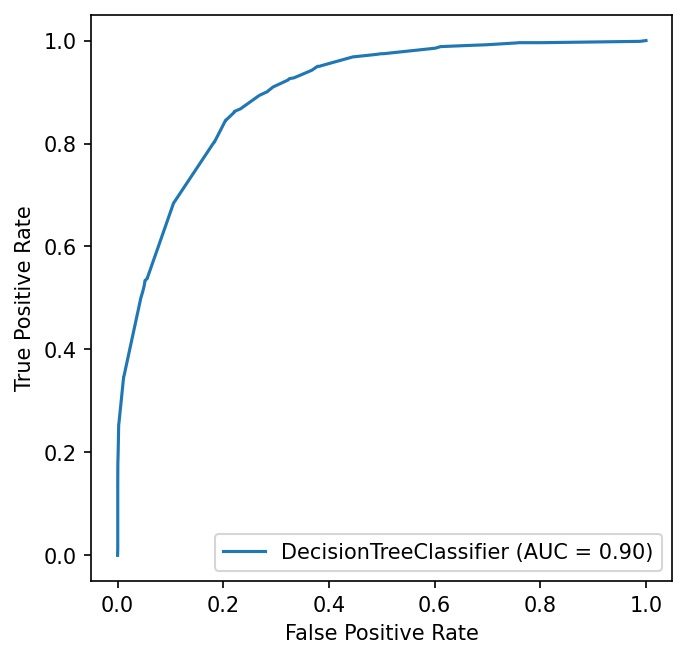

In [43]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(arbol1, X_test_1, y_test_1, ax=ax)
plt.show()

Se obtuvo una curva ROC interesante, crece bastante al principio y posee un valor de AUC de 0.90 que es bastante bueno. Concluimos que se trata de un buen modelo para empezar!

Veamos cómo queda la matriz de confusión

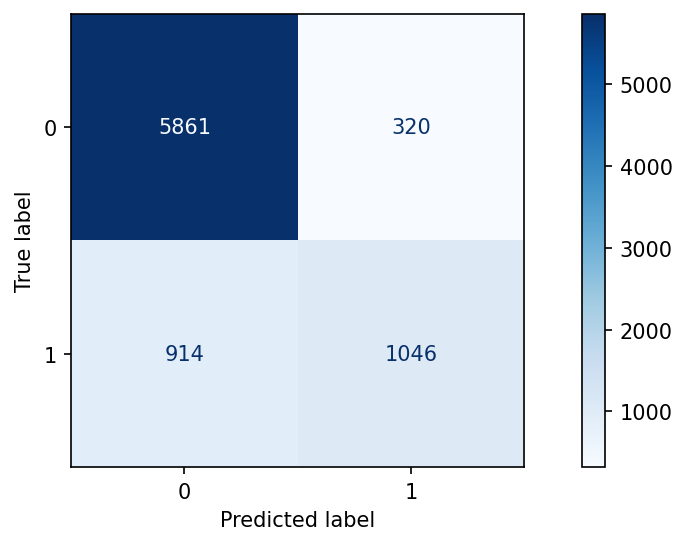

In [44]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
plot_confusion_matrix(arbol1, X_test_1, y_test_1, cmap=plt.cm.Blues, ax=ax)
plt.show()

La matriz de confusión dio decente, pero obviamente no excelente. Se puede observar que al modelo le cuesta predecir a los unos ya que a una gran parte de ellos los predice como 0.

### Modelo 2 - Preprocessing equilibrado

Este árbol será entrenado con todas las variables disponibles en el data frame, pero antes de entrenarlo se realizará un equilibrio de la variable objetivo (es decir, se desecharán gran parte de los datos de entrenamiento que no sean unos hasta que se alcace un equilibrio y sean 50% unos y 50% ceros)

Buscaremos una altura de forma similar al modelo anterior

Veamos qué sucede.

In [45]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112)
X_train_2, X_test_2, y_train_2, y_test_2 = preprocessing_equilibrado(X_train_2, X_test_2, y_train_2, y_test_2)

In [47]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112)

X_train_2, X_test_2, y_train_2, y_test_2 = preprocessing_equilibrado(X_train_2, X_test_2, y_train_2, y_test_2)

Buscaremos con GridSearch las mejores configuraciones para los siguientes hiperparámetros:
* criterion
* max_depth
* min_samples_leaf
* max_leaf_nodes
* min_impurity_decrease

Además se realizará mediante cross validation (Kfold con K = 10)

Y luego, si vemos que la altura dio muy alta buscaremos la menor altura entre ellas que obtengan un resultado similar.

In [49]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': range(5,22,2),
    'min_samples_leaf': np.linspace(0.0001, 0.001, 10),
    'max_leaf_nodes': [2**x for x in range(6, 18, 2)],
    'min_impurity_decrease': np.linspace(0, 0.1, 5)
}
model = DecisionTreeClassifier()

gscv_eq = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=10, verbose=4)

In [50]:
gscv_eq.fit(X_train_2, y_train_2)

Fitting 10 folds for each of 5400 candidates, totalling 54000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1506 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 2240 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 3074 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 4004 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5034 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7386 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 8708 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 10130 tasks      | e

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 22, 2),
                         'max_leaf_nodes': [64, 256, 1024, 4096, 16384, 65536],
                         'min_impurity_decrease': array([0.   , 0.025, 0.05 , 0.075, 0.1  ]),
                         'min_samples_leaf': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 ]),
                         'splitter': ['best']},
             scoring='roc_auc', verbose=4)

In [53]:
print(gscv_eq.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=13, max_leaf_nodes=64,
                       min_samples_leaf=0.0003)


Nuevamente vemos que se obtuvieron hiperparámetros diferentes a los default. La altura es relativamente pequeña, peor aún así nos interesa observar qué sucede con la altura.

In [54]:
alturas = range(1, 25)
model = DecisionTreeClassifier()
params = {
    'criterion': ['entropy'],
    'max_depth': alturas,
    'min_samples_leaf': [0.0003],
    'max_leaf_nodes': [64]
}
gscv_eq = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=10, verbose=4)

gscv_eq.fit(X_train_2, y_train_2)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    5.9s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 25),
                         'max_leaf_nodes': [64], 'min_samples_leaf': [0.0003]},
             scoring='roc_auc', verbose=4)

In [55]:
resultados = pd.DataFrame({"Altura": alturas, "RocAUC": gscv_base.cv_results_['mean_test_score']})

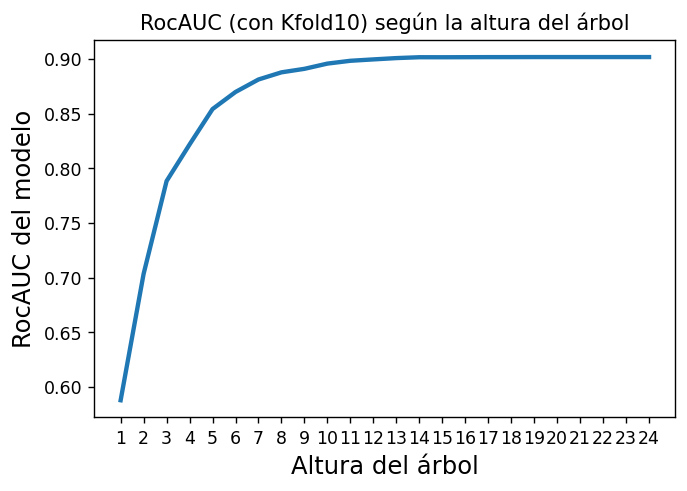

In [56]:
plt.figure(dpi=125)

sns.lineplot(data=resultados,
             x = "Altura",
             y = "RocAUC",
             palette="tab10", linewidth=2.5)

plt.title('RocAUC (con Kfold10) según la altura del árbol')
plt.xlabel("Altura del árbol", fontsize=14)
plt.ylabel("RocAUC del modelo", fontsize=14)
plt.xticks(alturas)

plt.show()

Podemos ver que efectivamente parece que la altura adecuada es 13.

In [57]:
arbol2 = DecisionTreeClassifier(criterion='gini', min_samples_leaf=50, max_depth=13)
arbol2.fit(X_train_2, y_train_2)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=50)

Veamos un reporte de la clasificación

In [59]:
print(classification_report(y_test_2, arbol2.predict(X_test_2), digits=4))

              precision    recall  f1-score   support

           0     0.9479    0.7739    0.8521      6182
           1     0.5482    0.8657    0.6713      1959

    accuracy                         0.7960      8141
   macro avg     0.7480    0.8198    0.7617      8141
weighted avg     0.8517    0.7960    0.8086      8141



Se obtuvieron nuevamente resultados muy intersantes, un accuracy de 79.6%, un valor muy inferior al obtenido en la primera parte del trabajo práctico.

Sin embargo el modelo destaca en las otras métricas, la precisión de ceros es altísima (94.8%). Los valores de Recall para unos es muy alto, sin embargo esto se ve opacado con el pobre valor de recall obtenido para ceros (que es la clase mayoritaria). Dados estos valores inusuales nos interesa observar cómo se comporta la curva ROC y su puntuación AUC final. Veamos

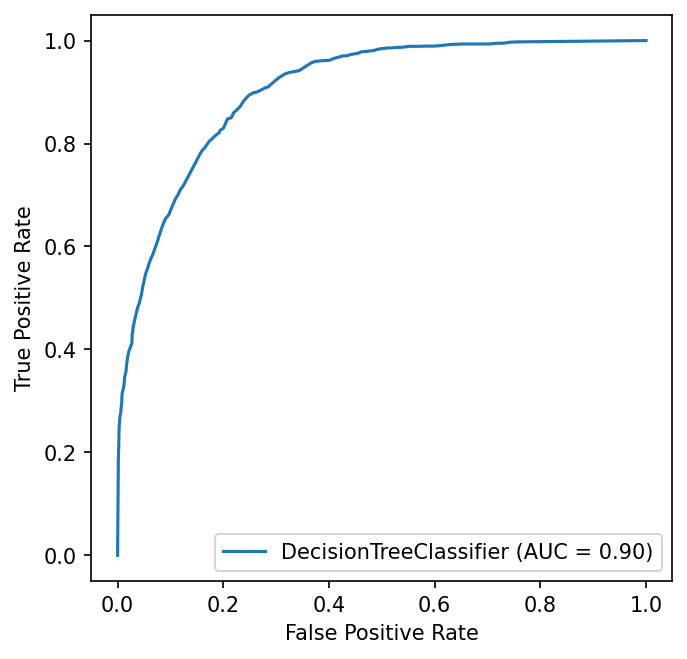

In [60]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(arbol2, X_test_2, y_test_2, ax=ax)
plt.show()

Se obtuvo un valor para AUC similar al modelo anterior... esto probablemente se deba a la mejor performance del modelo para el recall de unos y la altísima precisión de ceros.

Creemos que este modelo se trata de uno muy peculiar, pero no necesariamente del mejor para precedir, basta con ver la matriz de confusión para notar lo comentado:

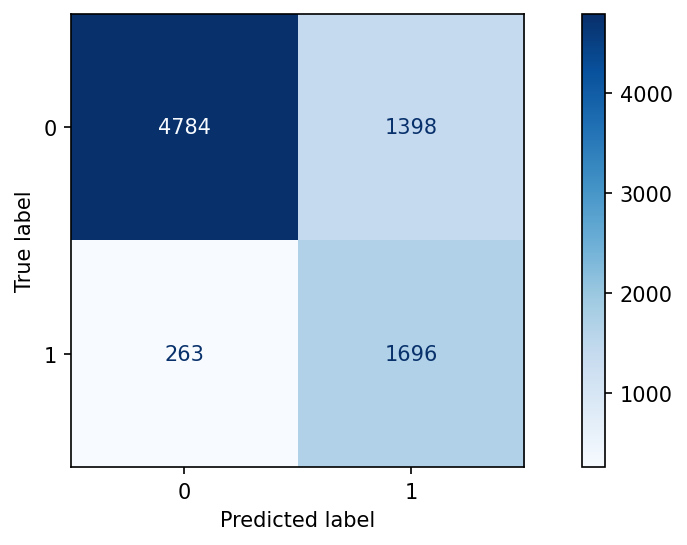

In [62]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
plot_confusion_matrix(arbol2, X_test_2, y_test_2, cmap=plt.cm.Blues, ax=ax)
plt.show()

Vemos que a diferencia de antes, son pocos los Falsos negativos. Pero aumentó muchísimo la cantidad de falsos positivos. Cuyo valor es similar al de verdaderos positivos.

Además que el accuracy es muy pobre (ya que se pierden muchos ceros)

# Persistiendo los modelos

In [63]:
import pickle

In [64]:
pickle.dump(arbol1, open("Modelos/Tree/tree1.pickle", "wb"))
pickle.dump(arbol2, open("Modelos/Tree/tree2.pickle", "wb"))

# Predicción de HoldOut

Usaremos para predecir el árbol obtenido para el preprocessing equilibrado.

In [65]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv, drop_first=True)

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X, drop_first=True)
    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    return ids, X

In [66]:
arbol2 = pickle.load(open("Modelos/Tree/tree2.pickle", "rb"))

In [67]:
ids, X = holdout()

In [69]:
utils.escribir_holdout(arbol2.predict(X), "1 - Tree", ids)